In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

import sklearn
from sklearn.model_selection import KFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold # Split data
from sklearn.metrics import accuracy_score # Compute accuracy
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer, MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

### Loading Data and Converting Categorical data to Numeric

In [2]:
all_data = pd.read_csv("../Data/preprocessed_synthetic_data_fma.csv")
all_data.shape

(201213, 525)

In [3]:
all_data.head()

,track_id,title,title.1,location,name,bit_rate,genre_id,chroma_cens,chroma_cens.1,chroma_cens.2,...,tonnetz.39,tonnetz.40,tonnetz.41,zcr,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6
0,2,AWOL - A Way Of Life,Food,New Jersey,AWOL,256000,21.0,7.180653,5.230309,0.249321,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,AWOL - A Way Of Life,Electric Ave,New Jersey,AWOL,256000,21.0,1.888963,0.760539,0.345297,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,AWOL - A Way Of Life,This World,New Jersey,AWOL,256000,21.0,0.527563,-0.077654,-0.279610,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,Constant Hitmaker,Freeway,NaN,Kurt Vile,192000,10.0,3.702245,-0.291193,2.196742,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,Niris,Spiritual Level,Colchester England,Nicky Cook,256000,17.0,-0.193837,-0.198527,0.201546,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [4]:
# Convert categorical to numeric (Label Encode)
def label_encode(col, df):
  Label_Encoder = LabelEncoder()
  df[col] = df[col].astype(str)
  encoded_col = Label_Encoder.fit_transform(df[col])
  return encoded_col

for col in ["title", "title.1", "location", "name"]:
  all_data[col] = label_encode(col, all_data)

### Mapping Genre IDs to Names

In [5]:
# Map genre_id to names
genres = pd.read_csv("../Data/genres.csv")
data_vals = all_data["genre_id"].dropna()

genre_id = [int(val) for val in data_vals.unique()]

genre_top_dict = dict(zip(genre_id, genres["title"]))
print(genre_top_dict)

{21: 'Avant-Garde', 10: 'International', 17: 'Blues', 58: 'Jazz', 32: 'Classical', 4: 'Novelty', 1: 'Comedy', 25: 'Old-Time / Historic', 26: 'Country', 38: 'Pop', 27: 'Disco', 2: 'Rock', 12: 'Easy Listening', 89: 'Soul-RnB', 15: 'Electronic', 36: 'Sound Effects', 3: 'Folk', 66: 'Soundtrack', 41: 'Funk', 65: 'Spoken', 11: 'Hip-Hop', 1235: 'Audio Collage', 49: 'Punk', 250: 'Post-Rock', 138: 'Lo-Fi', 45: 'Field Recordings', 184: 'Metal', 224: 'Noise', 514: 'Psych-Folk', 297: 'Krautrock', 186: 'Jazz: Vocal', 181: 'Experimental', 404: 'Electroacoustic', 182: 'Ambient Electronic', 98: 'Radio Art', 538: 'Loud-Rock', 6: 'Latin America', 400: 'Drone', 240: 'Free-Folk', 107: 'Noise-Rock', 183: 'Psych-Rock', 81: 'Bluegrass', 5: 'Electro-Punk', 456: 'Radio', 64: 'Indie-Rock', 88: 'Industrial', 236: 'No Wave', 19: 'Free-Jazz', 33: 'Experimental Pop', 8: 'French', 97: 'Reggae - Dub', 362: 'Afrobeat', 13: 'Nerdcore', 137: 'Garage', 443: 'Indian', 74: 'New Wave', 314: 'Post-Punk', 130: 'Sludge', 296: 

### Finding the Major Genres w/ Significant Sample Sizes

In [6]:
# Take genres that have atleast 6000 samples
genre_count = all_data.groupby('genre_id').agg({'genre_id':'count'})['genre_id']

<AxesSubplot:>

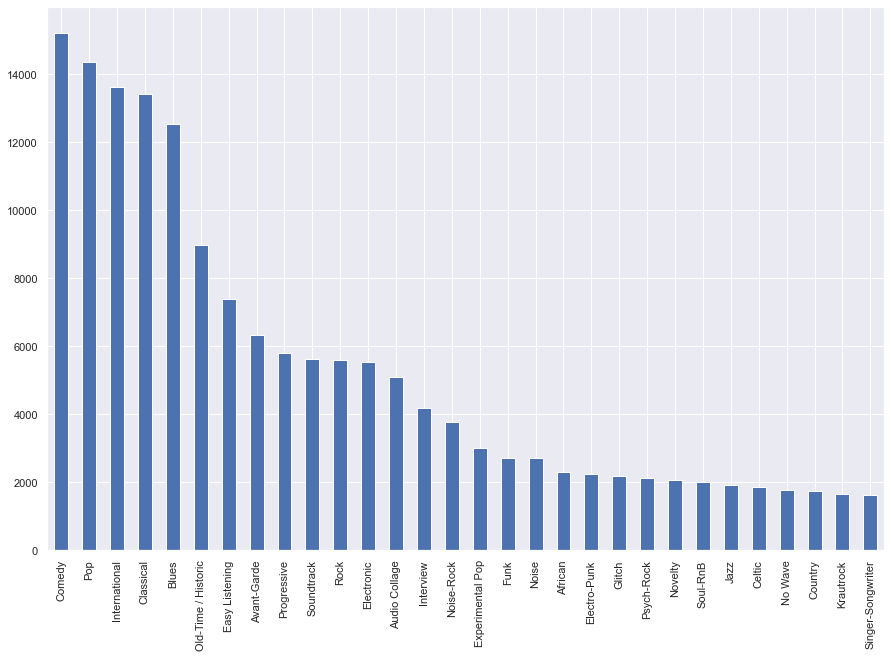

In [7]:
df = pd.DataFrame()
df['genre_id'] = data_vals
df['genre_name'] = [genre_top_dict[id] for id in data_vals]
df['genre_name'].value_counts()[:30].plot(figsize=(15,10), kind='bar')

In [8]:
major_genres = genre_count[genre_count > 6000].index.values
minor_genres = genre_count[genre_count <= 6000].index.values
# print(genre_count)
print("Major genres: {} \nMinor Genres: {}".format(major_genres, minor_genres))

Major genres: [ 1. 10. 12. 17. 21. 25. 32. 38.] 
Minor Genres: [   2.    3.    4.    5.    6.    7.    8.    9.   11.   13.   14.   15.
   16.   18.   19.   20.   26.   27.   31.   33.   36.   41.   42.   45.
   46.   47.   49.   53.   58.   64.   65.   66.   70.   71.   74.   81.
   83.   85.   86.   88.   89.   90.   94.   97.   98.  100.  101.  102.
  103.  107.  113.  125.  130.  137.  138.  167.  169.  170.  172.  177.
  179.  181.  182.  183.  184.  185.  186.  187.  224.  232.  236.  240.
  247.  250.  267.  286.  296.  297.  314.  322.  337.  359.  360.  361.
  362.  378.  400.  401.  404.  428.  439.  440.  441.  442.  443.  444.
  456.  468.  491.  495.  504.  514.  538.  539.  542.  580.  602.  619.
  659.  693.  695.  741.  808.  810.  811.  906. 1032. 1235.]


In [9]:
[genre_top_dict[id] for id in set(major_genres)]

['Classical',
 'Comedy',
 'Pop',
 'International',
 'Easy Listening',
 'Blues',
 'Avant-Garde',
 'Old-Time / Historic']

### Only Keeping Data from the Major Genres

In [10]:
# Collect samples belonging to major_genres
all_data_new = all_data.iloc[[all_data['genre_id'][id] in set(major_genres) for id in range(len(all_data))]]
all_data_new.shape

(91901, 525)

In [11]:
all_data_new.to_csv(r'..\Data\final_preprocessed_data.csv', index=False)